C:\Users\asdfghjkl\AppData\Local\Temp\ipykernel_12392\401618005.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15, 10))


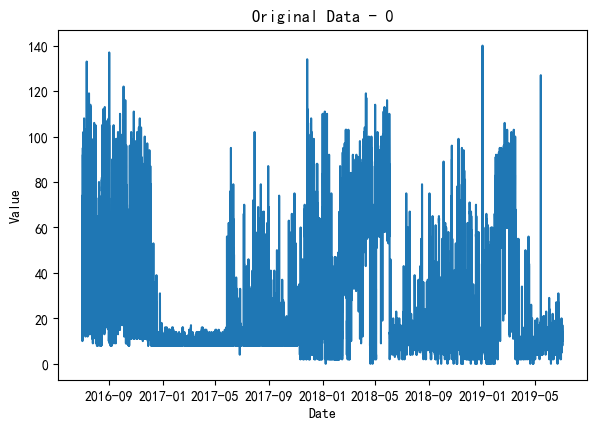

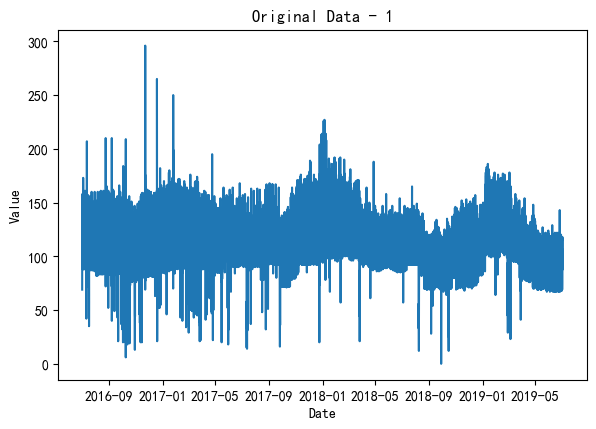

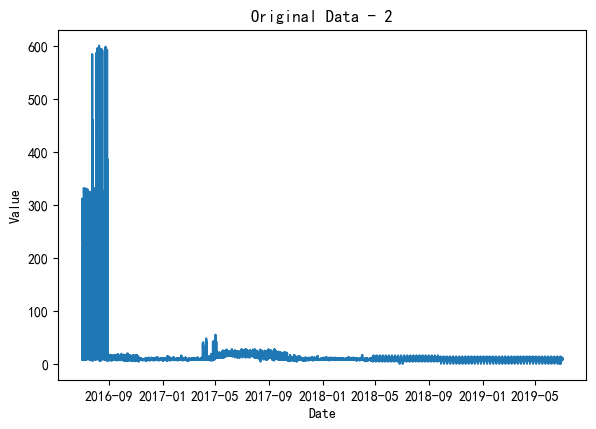

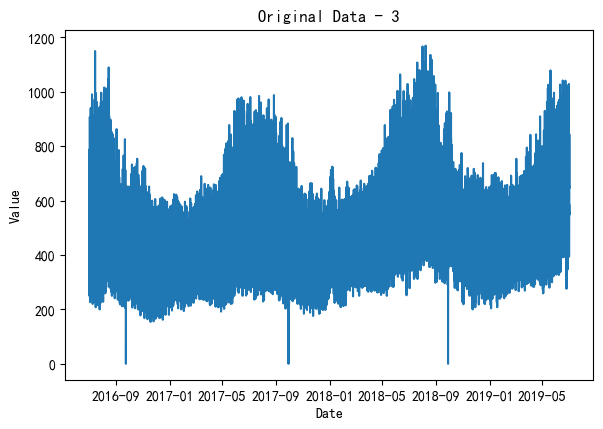

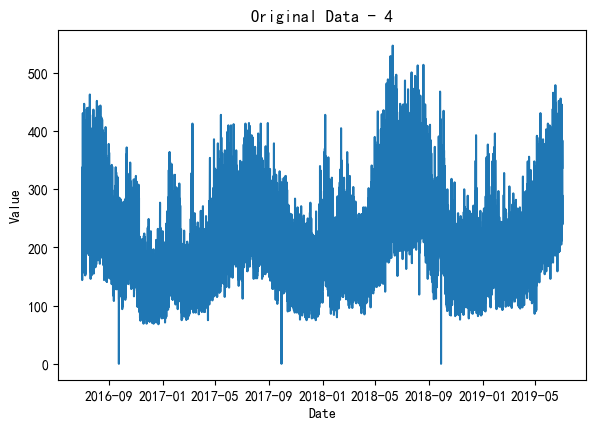

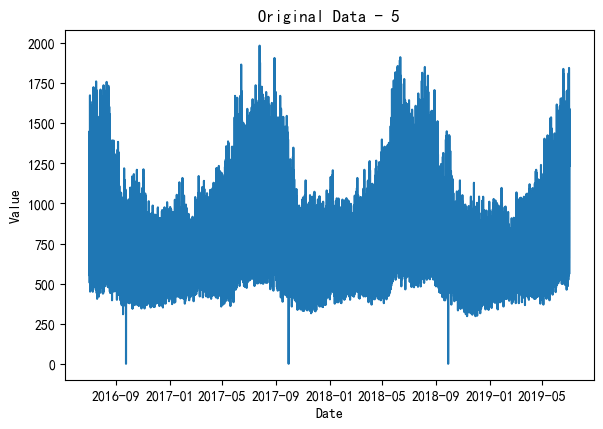

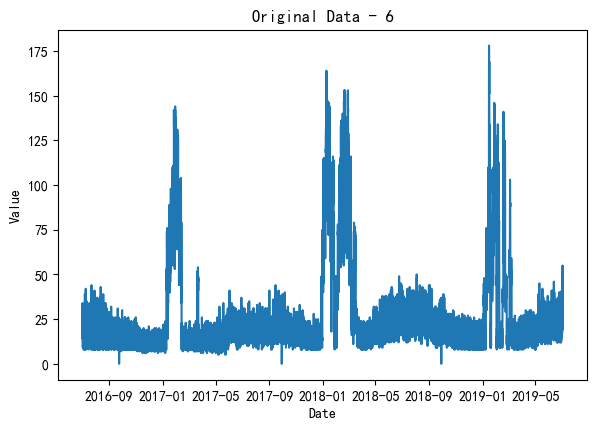

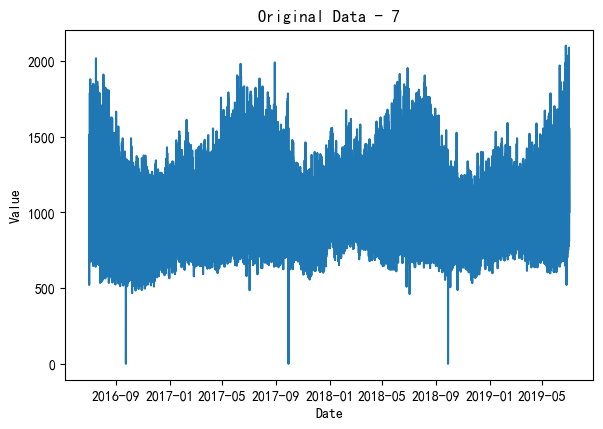

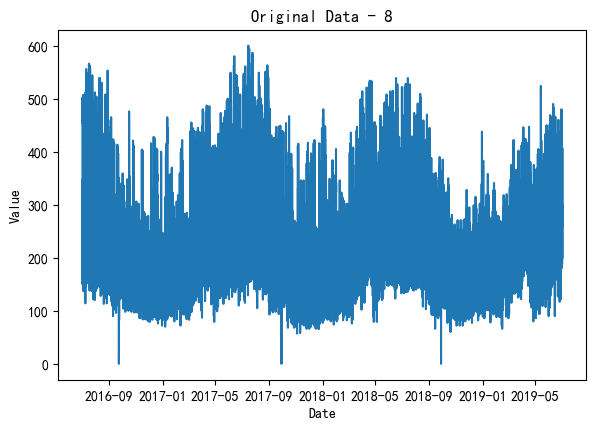

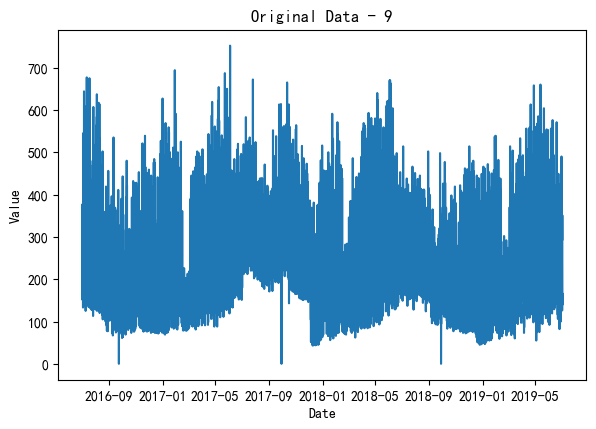

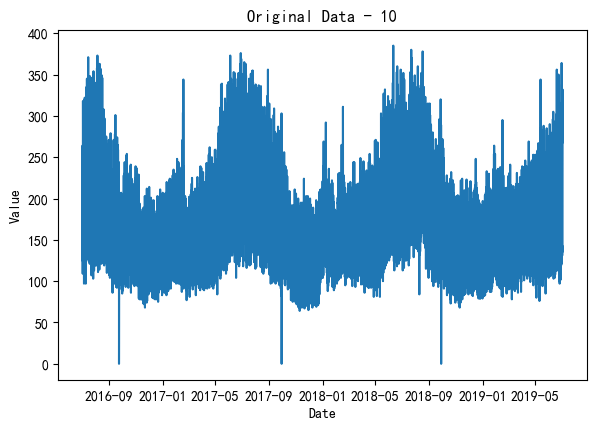

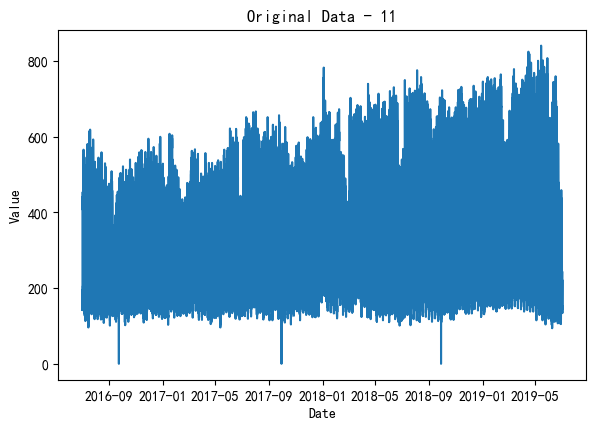

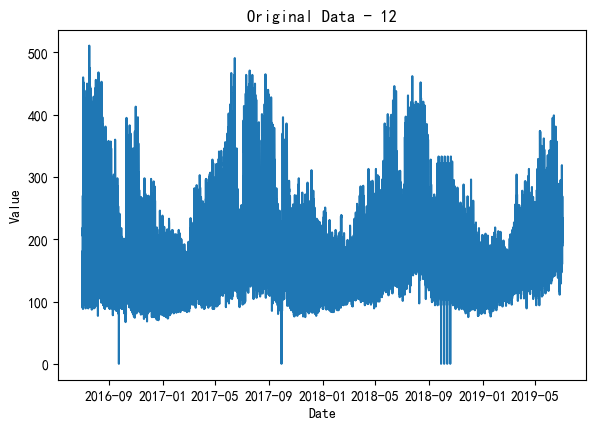

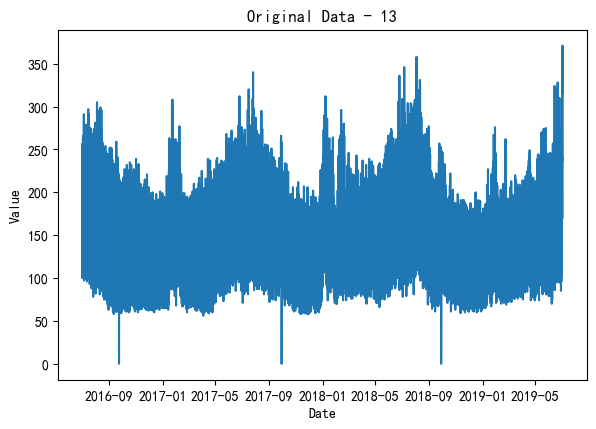

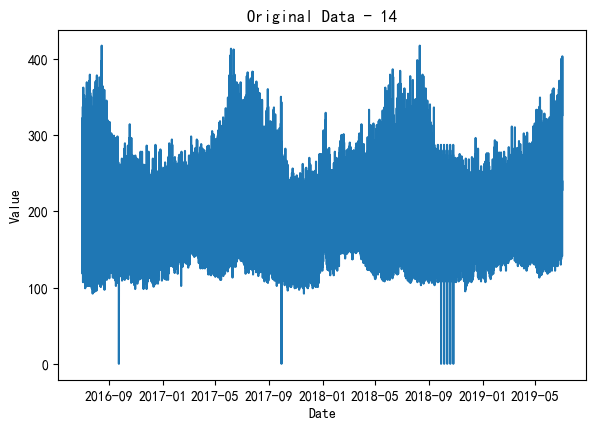

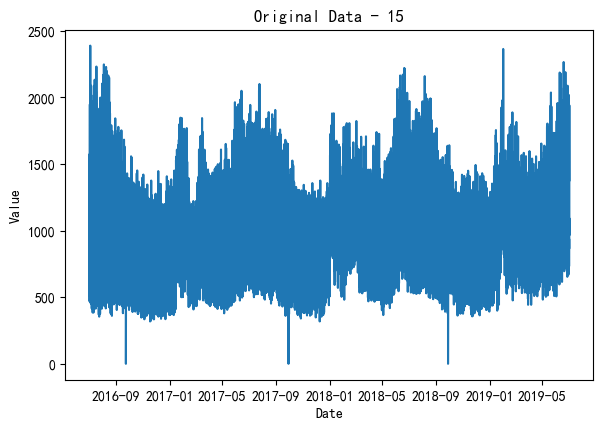

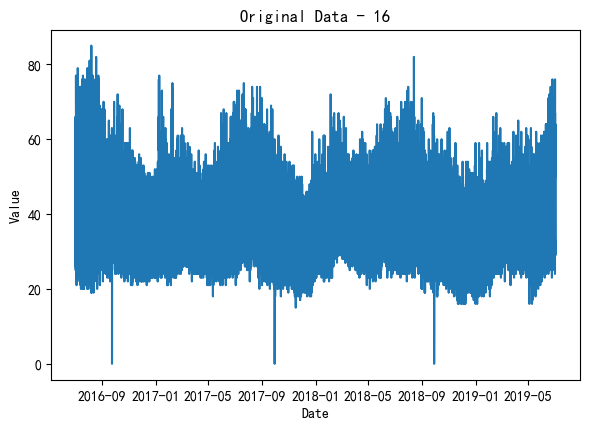

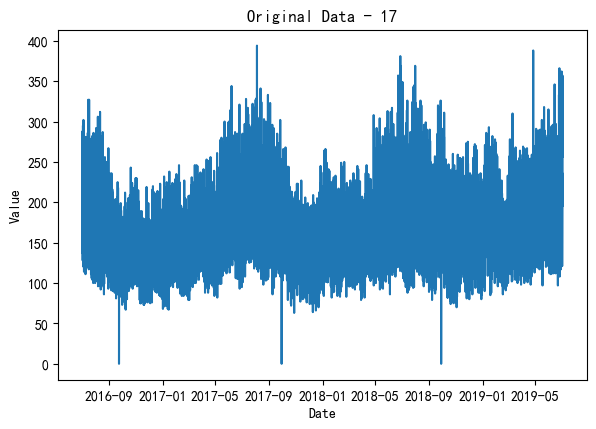

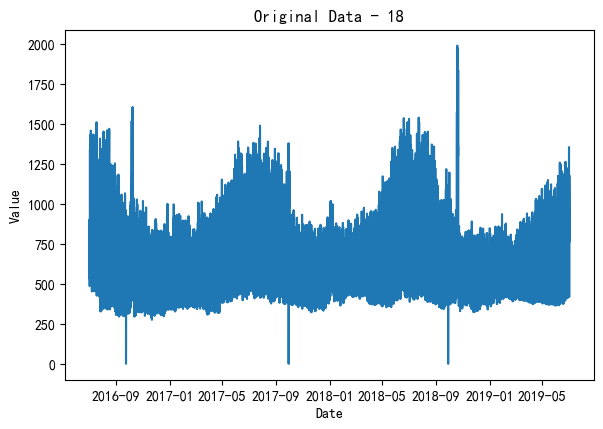

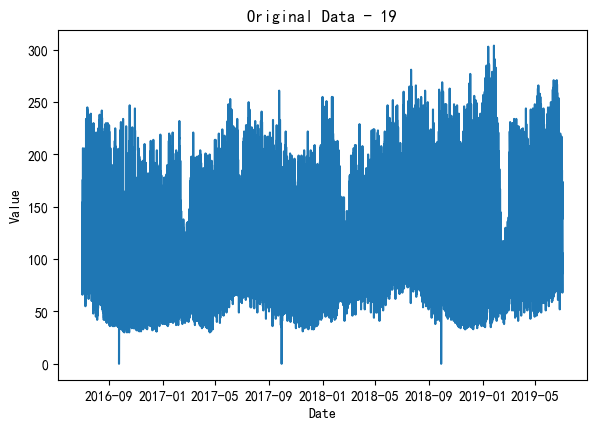

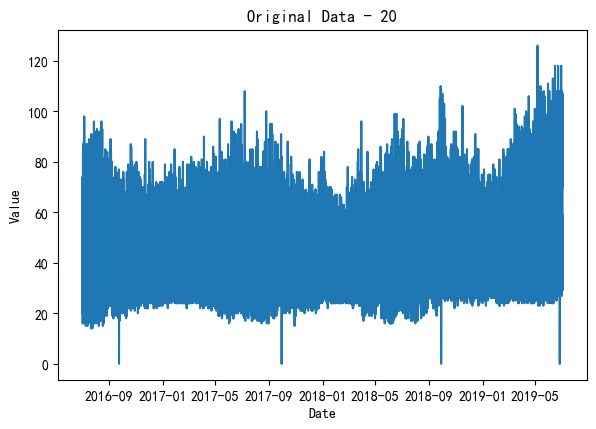

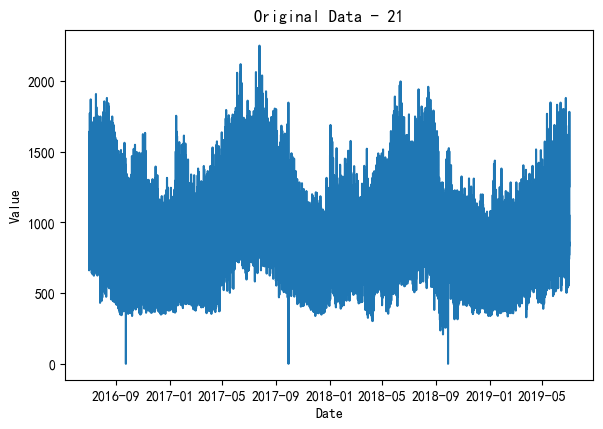

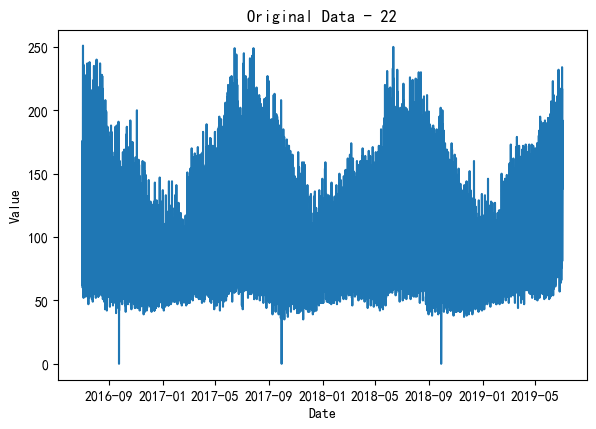

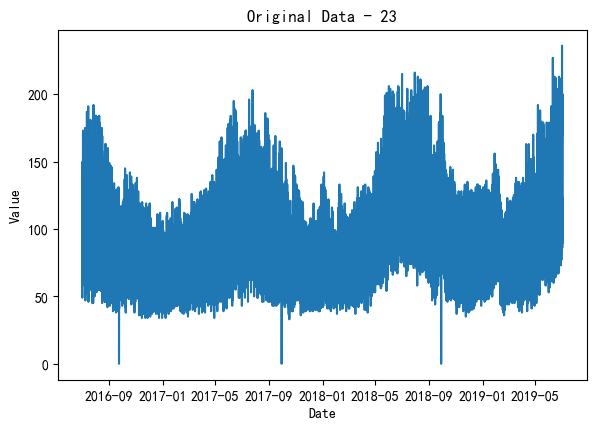

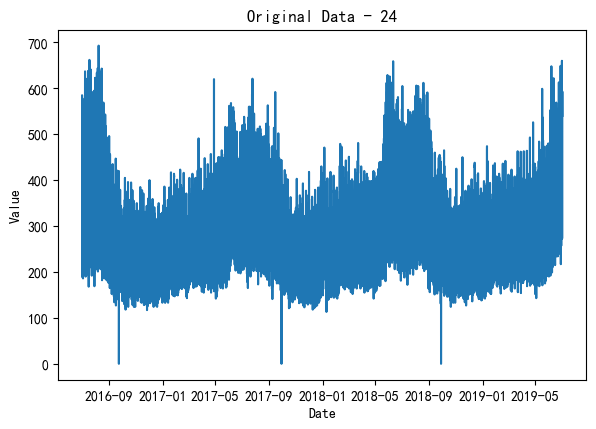

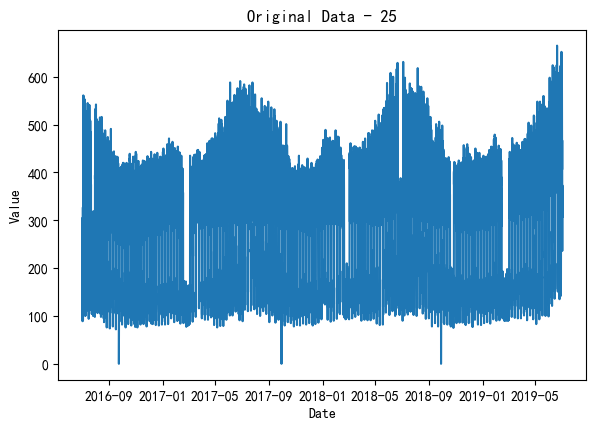

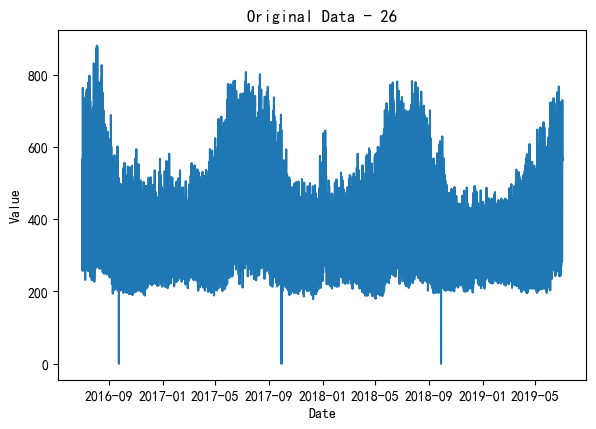

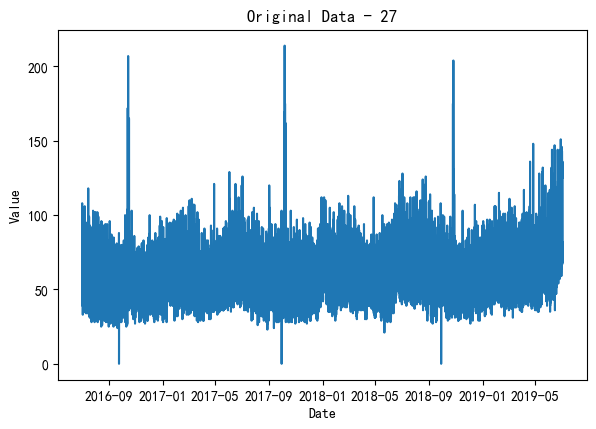

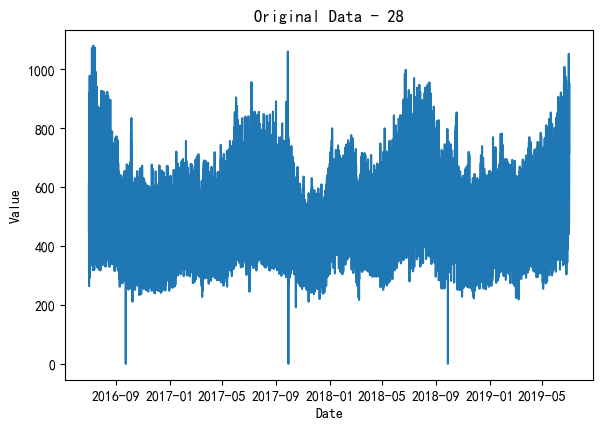

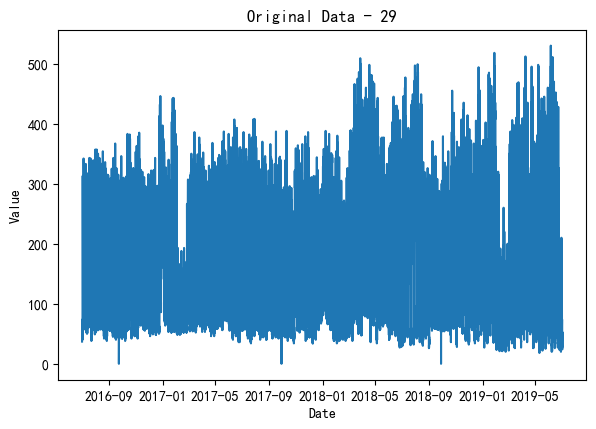

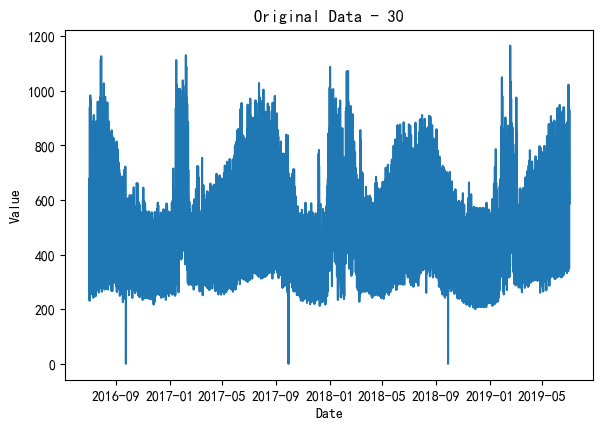

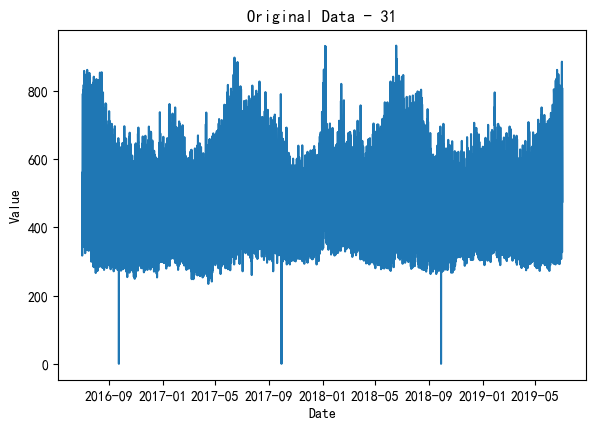

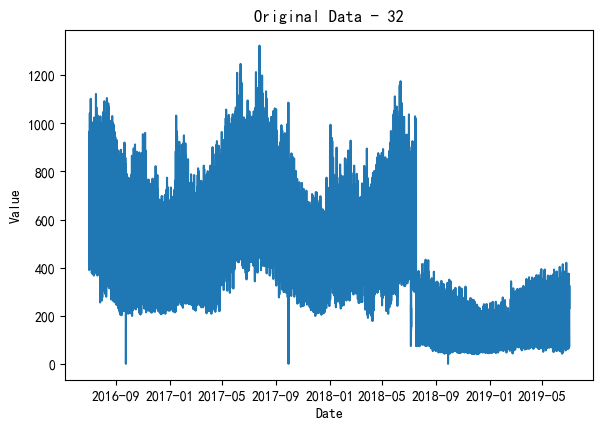

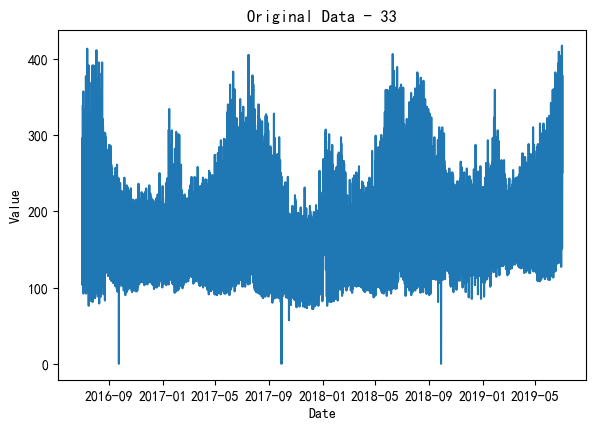

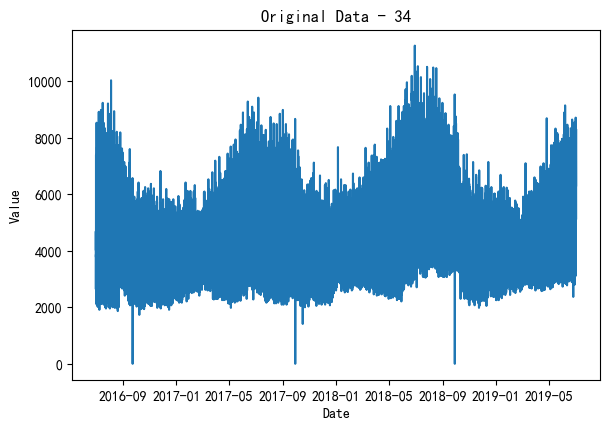

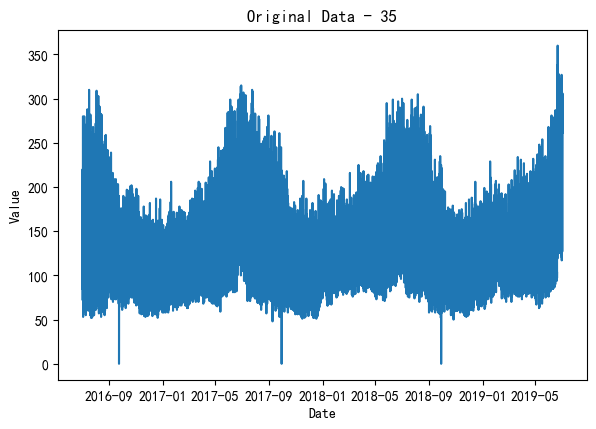

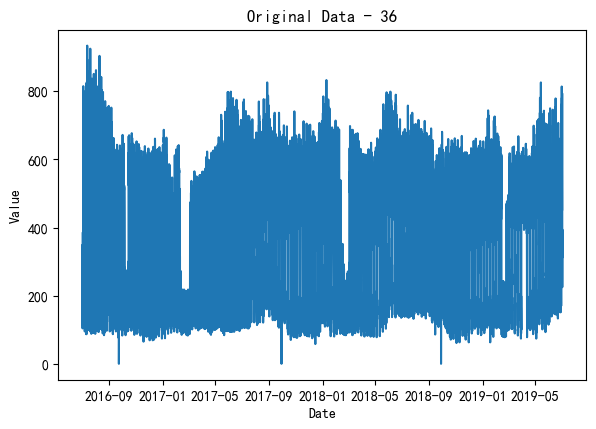

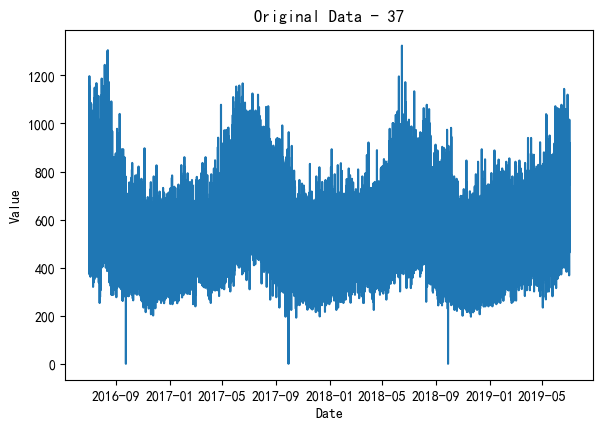

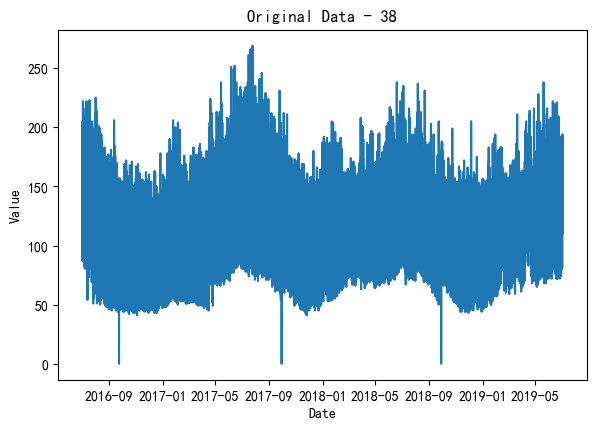

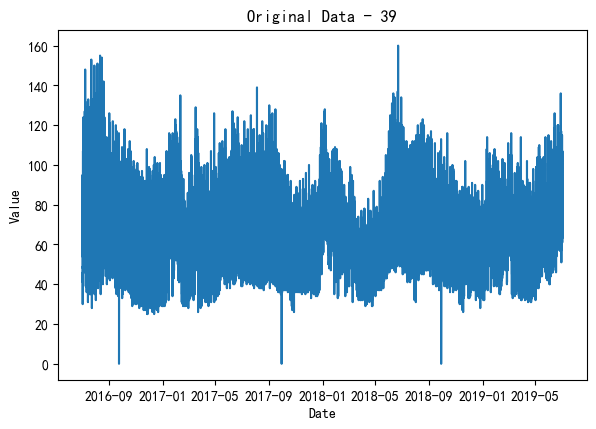

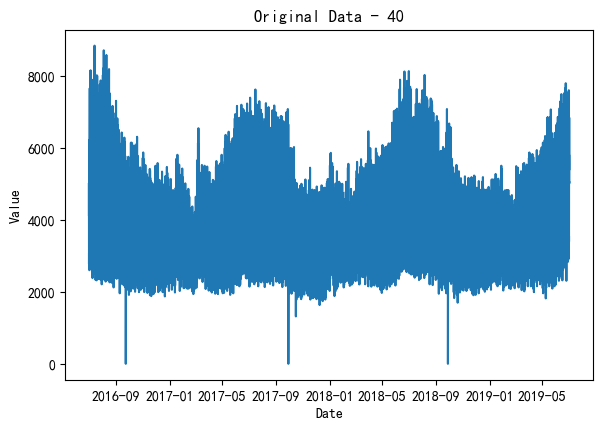

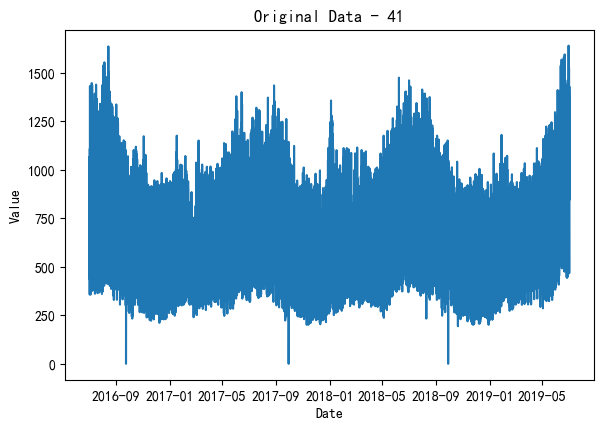

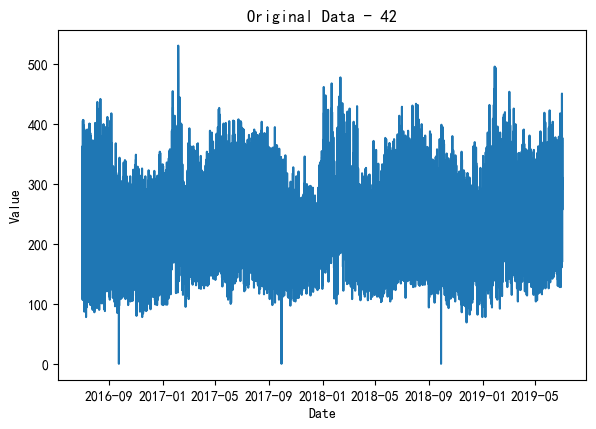

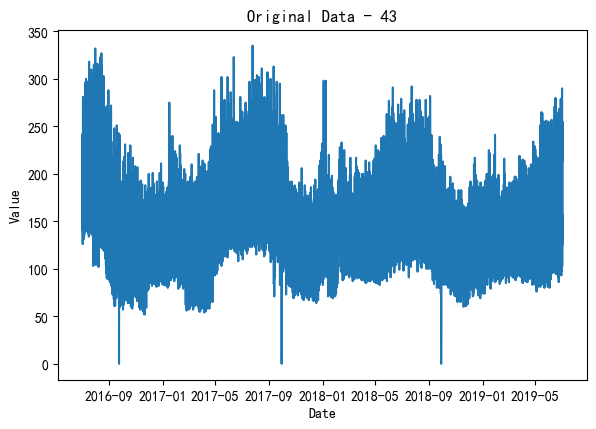

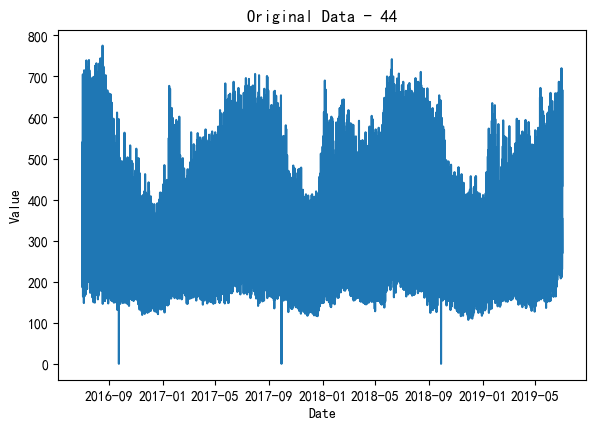

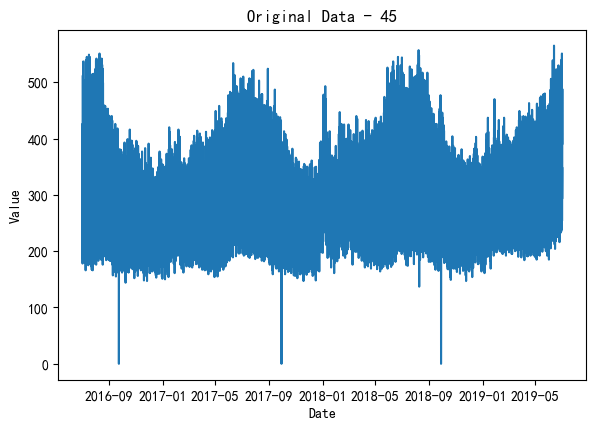

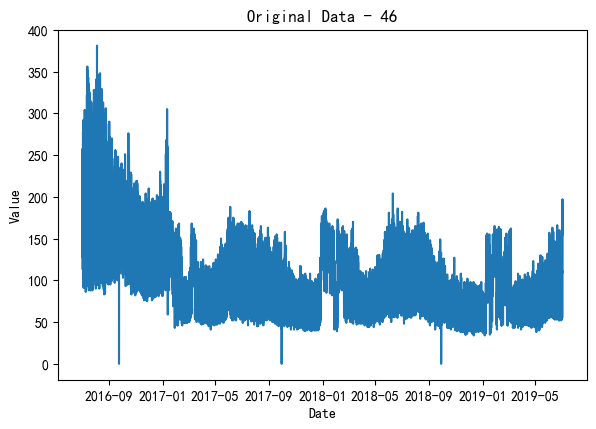

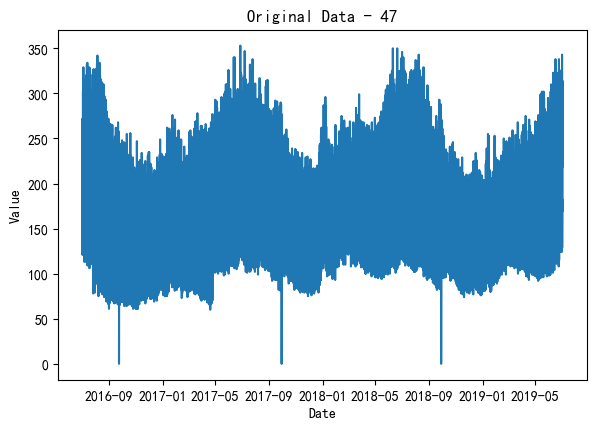

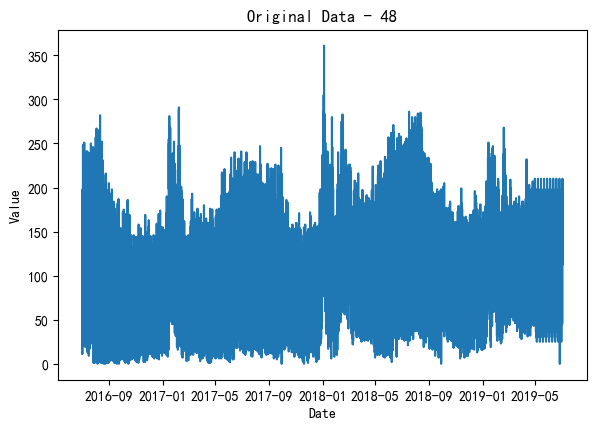

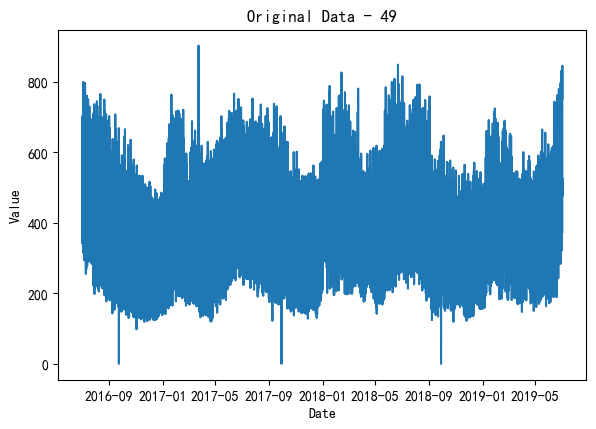

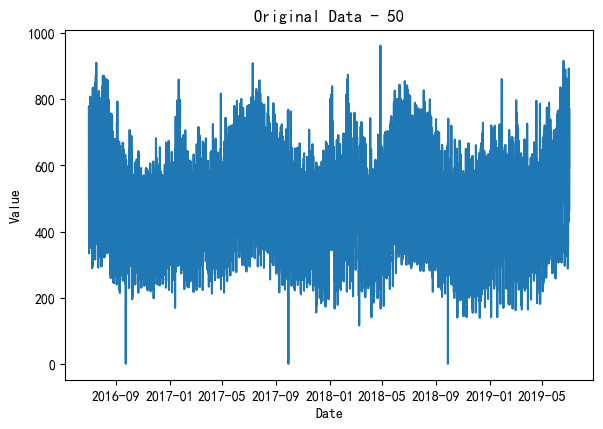

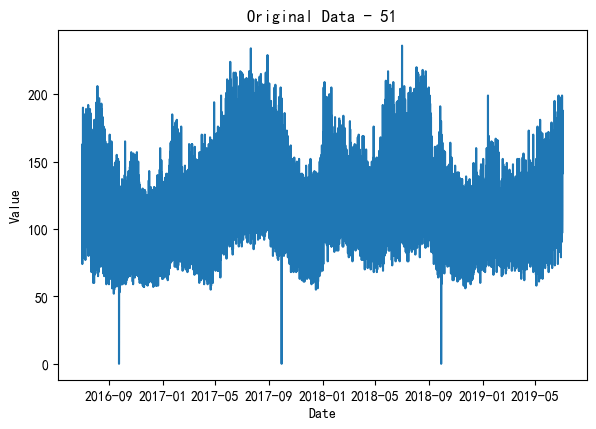

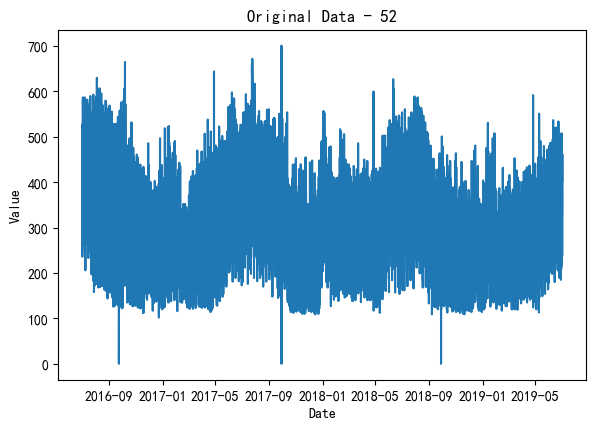

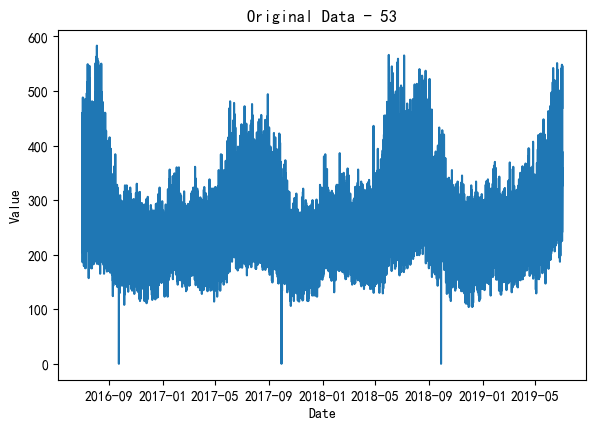

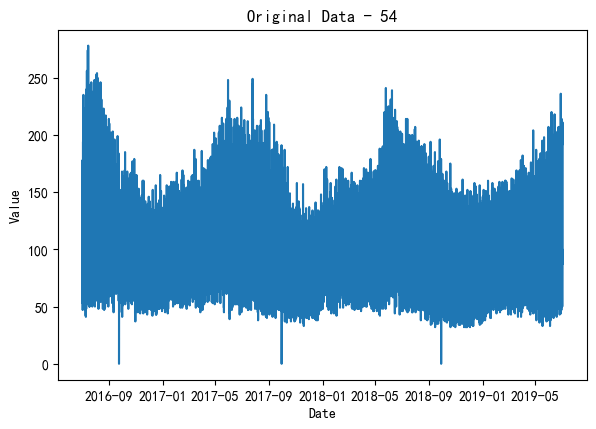

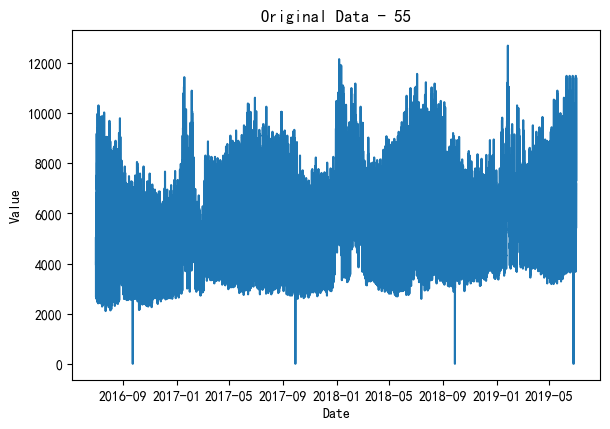

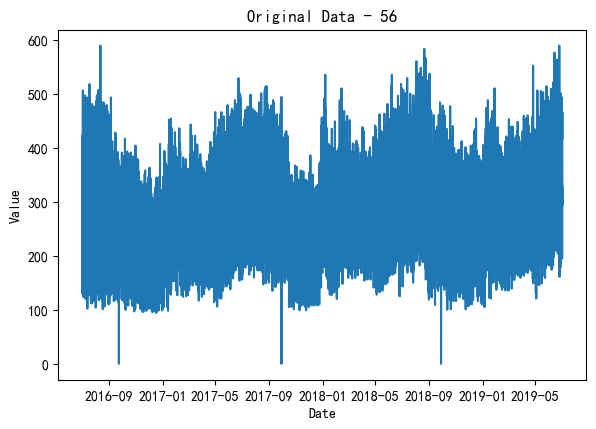

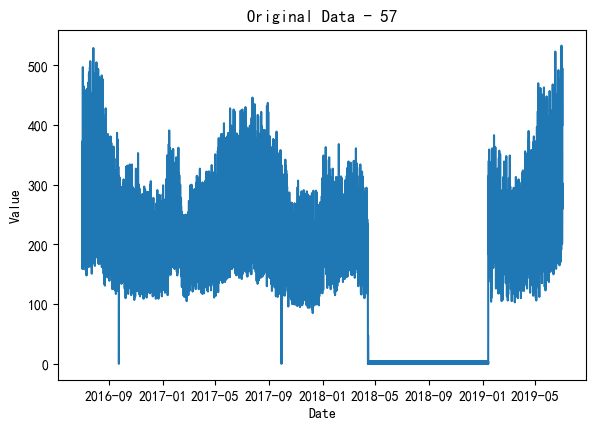

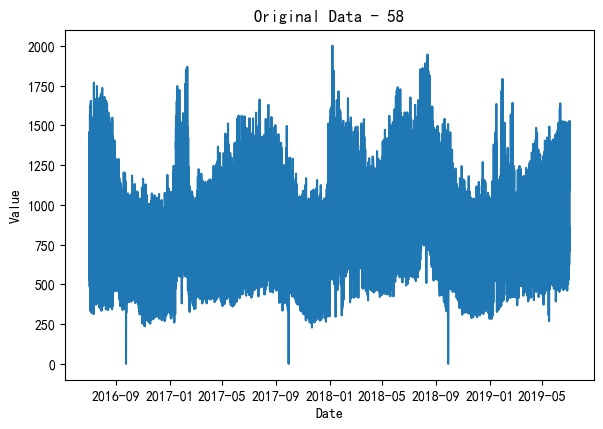

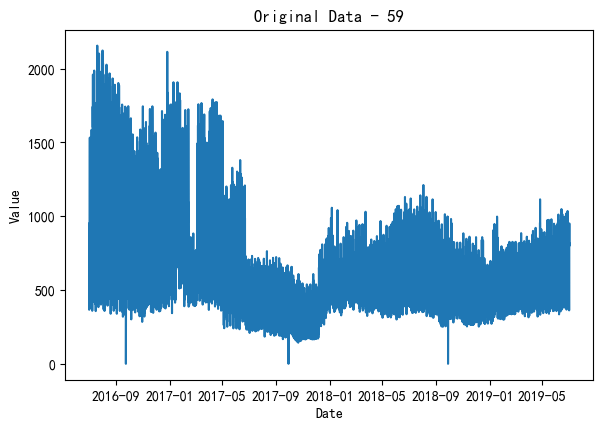

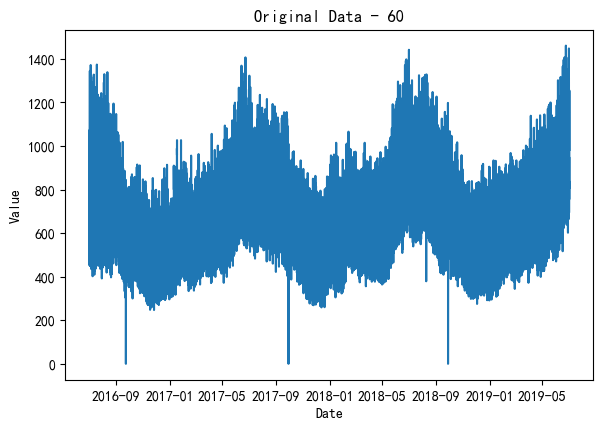

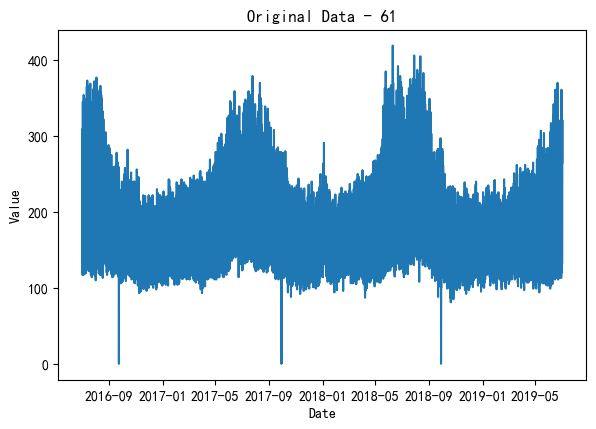

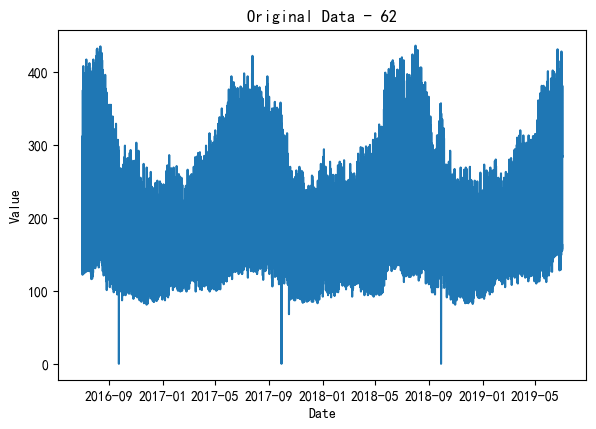

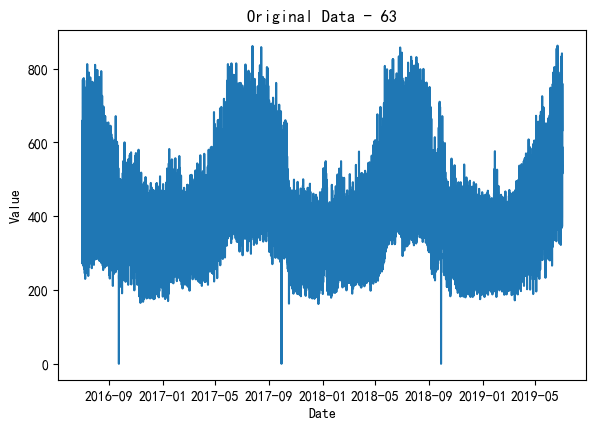

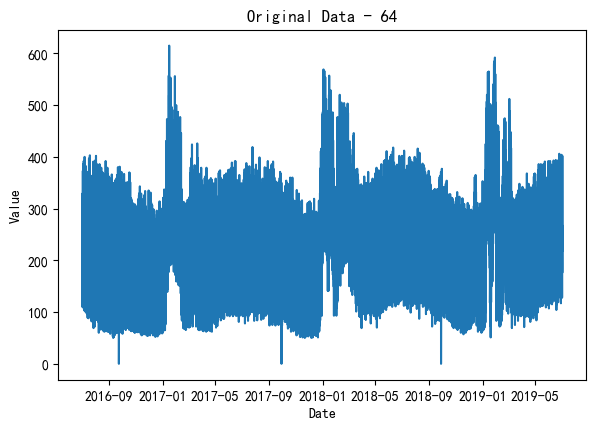

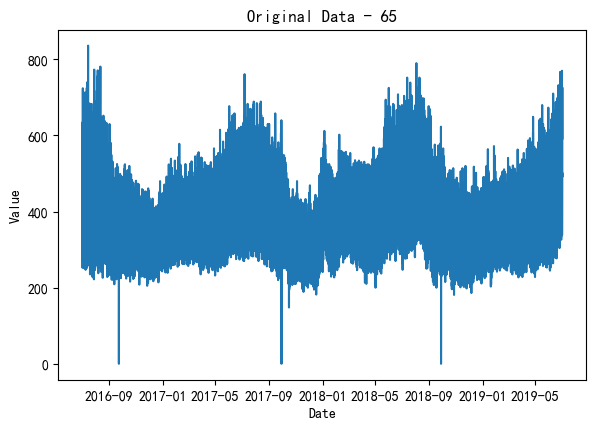

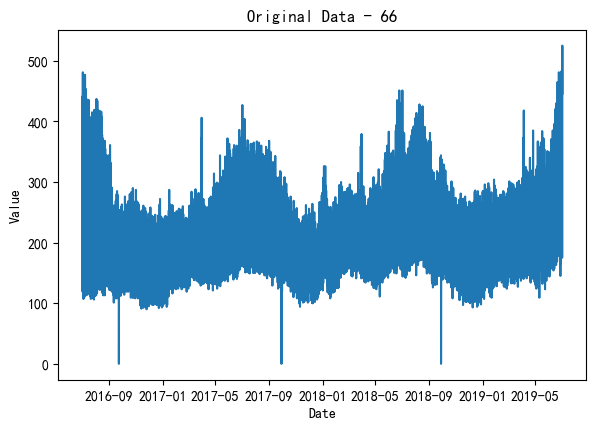

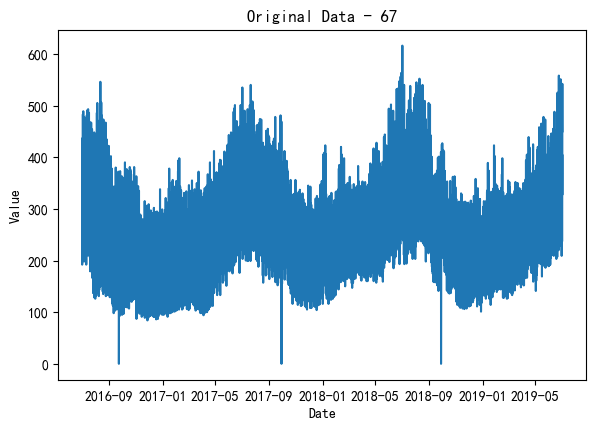

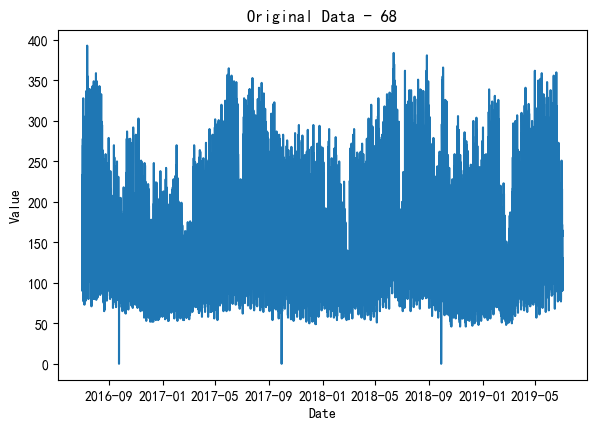

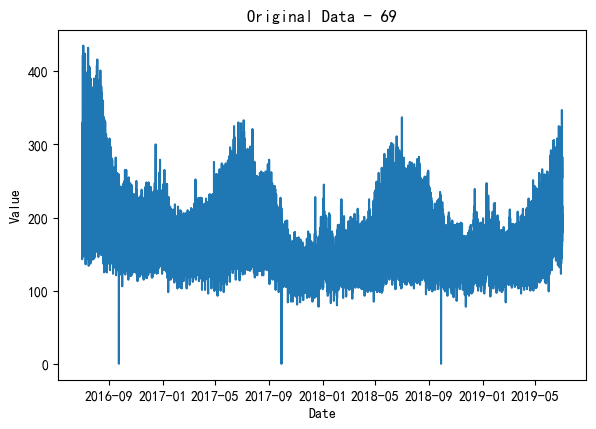

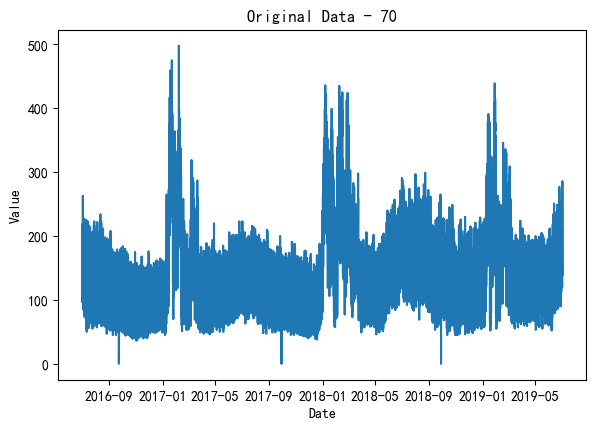

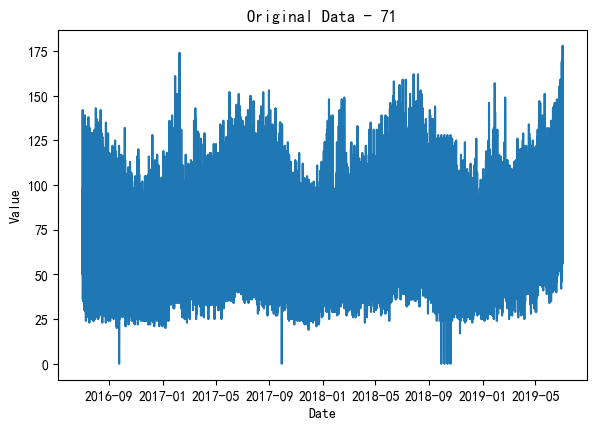

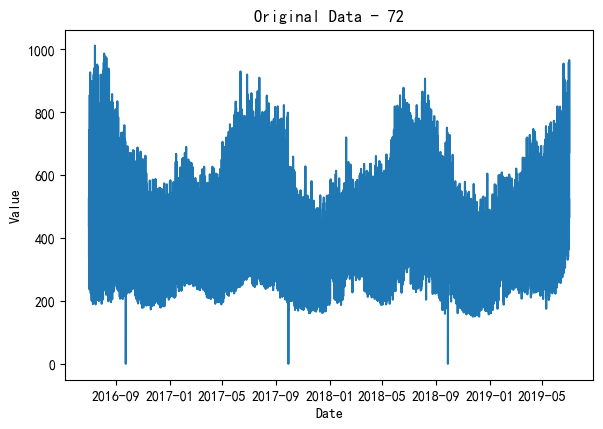

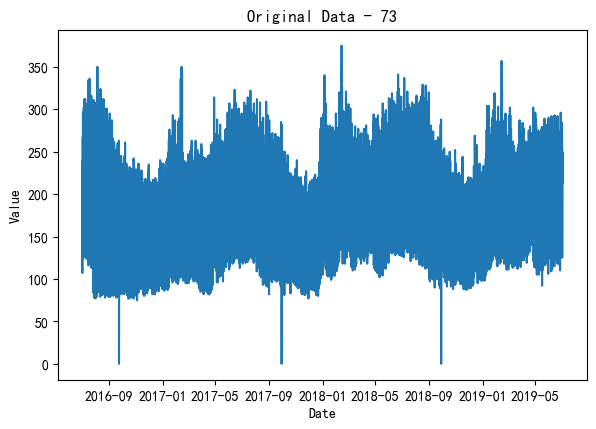

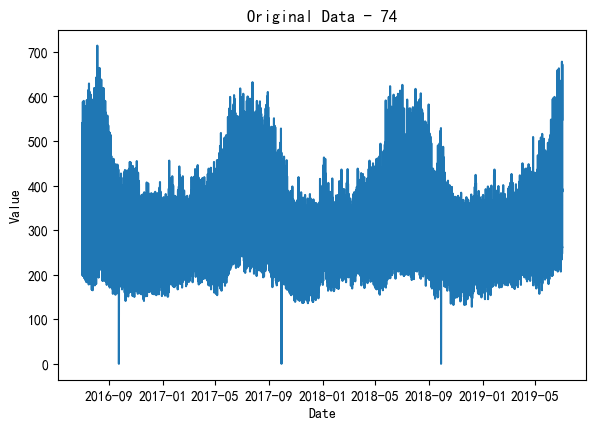

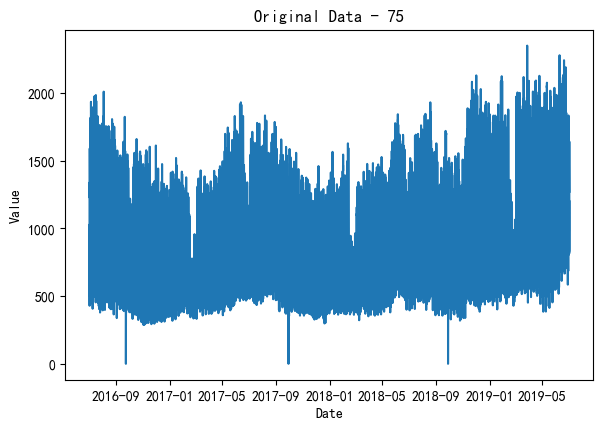

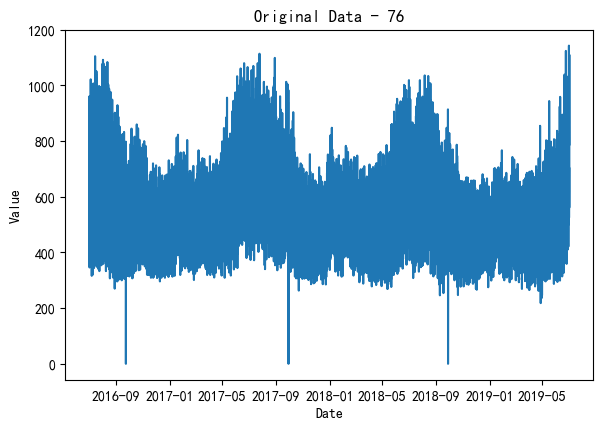

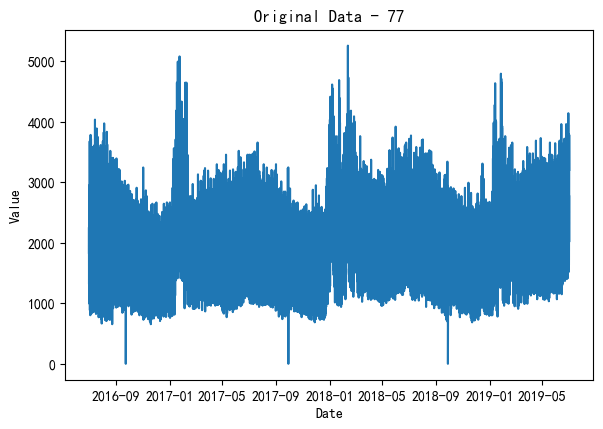

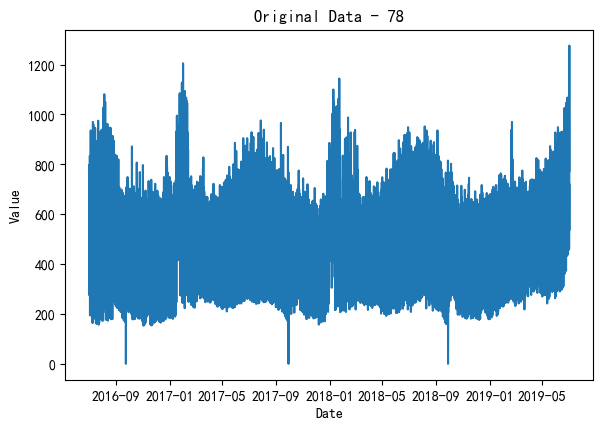

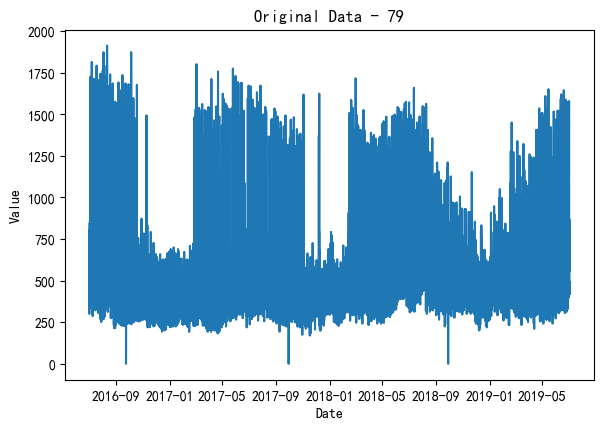

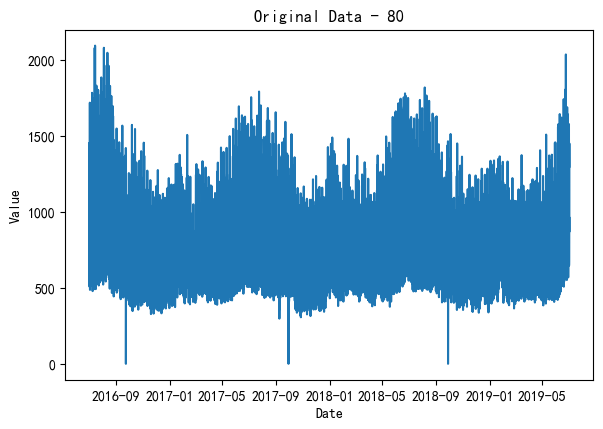

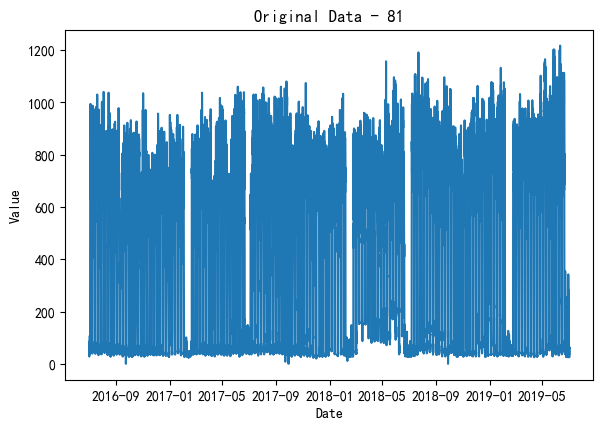

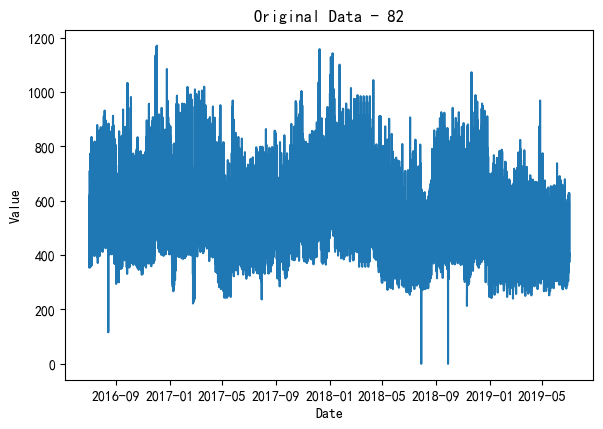

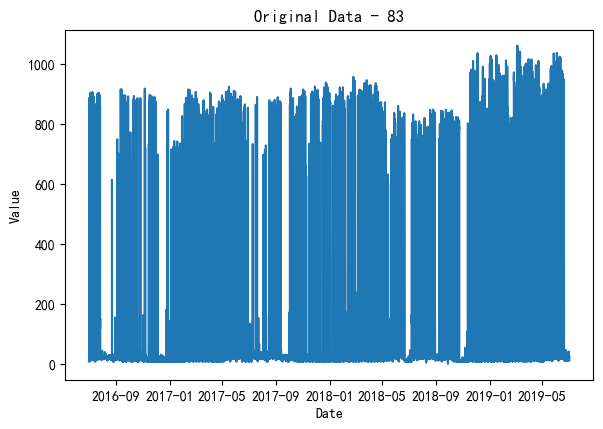

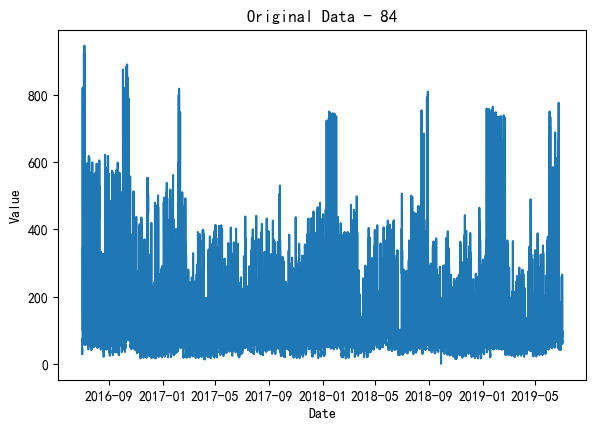

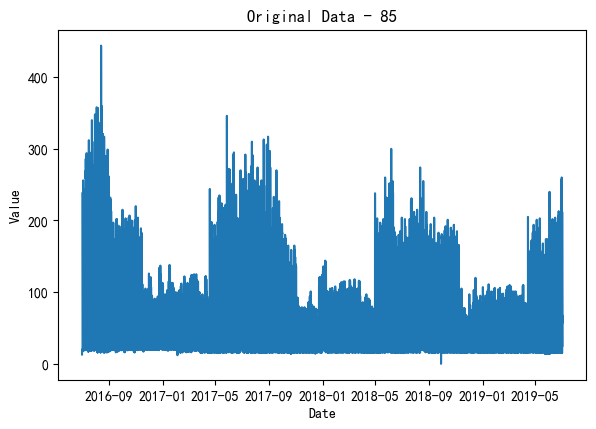

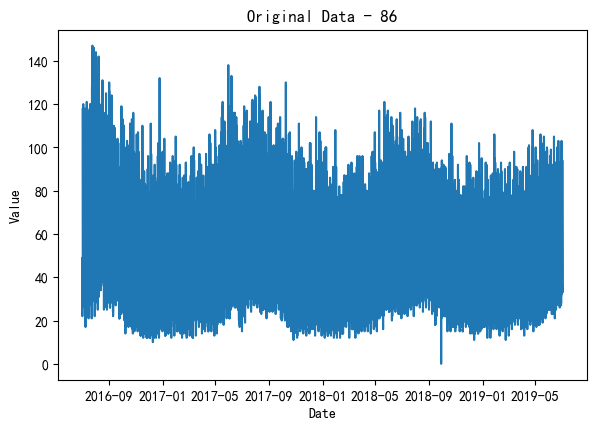

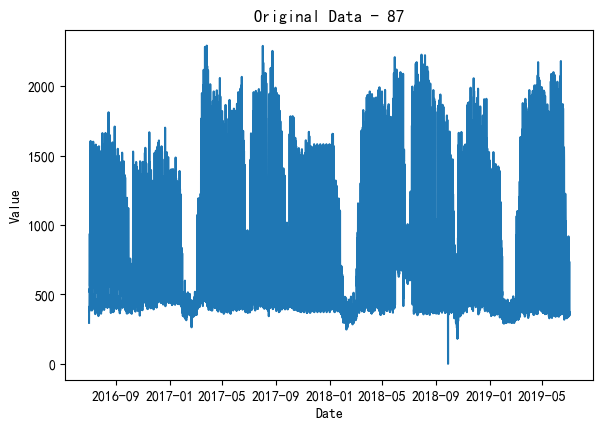

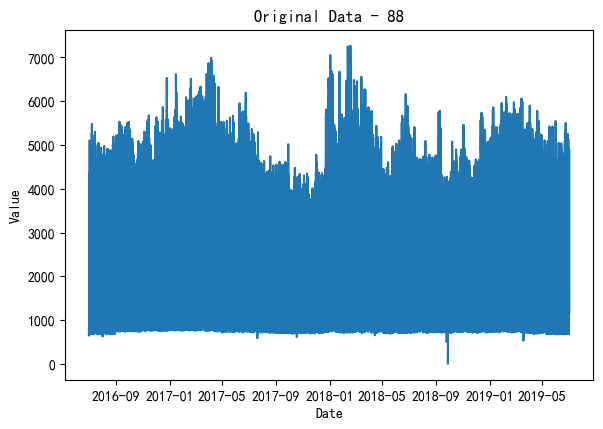

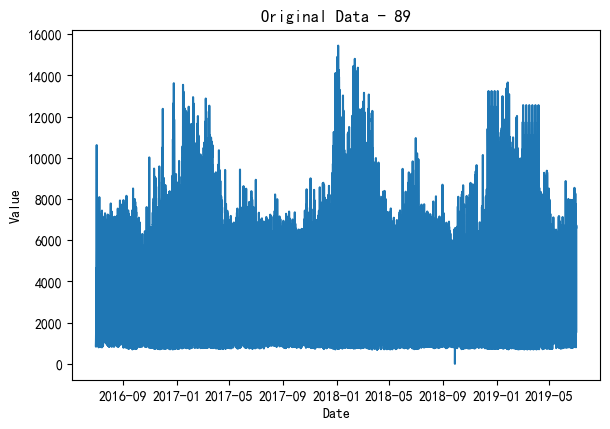

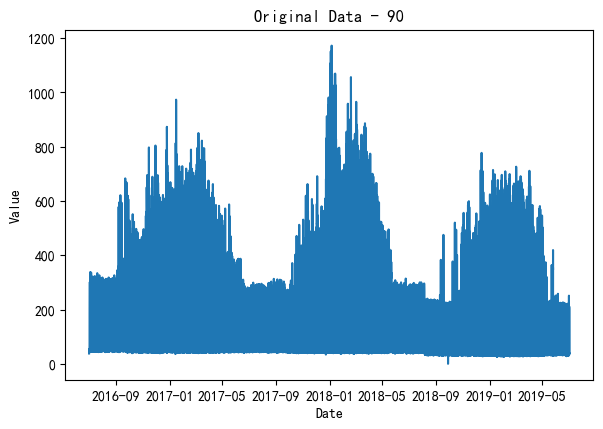

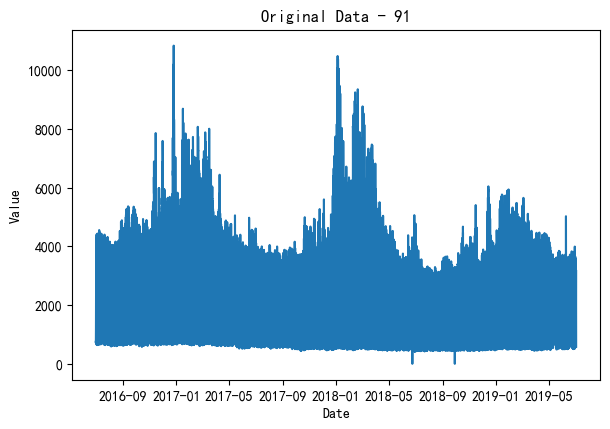

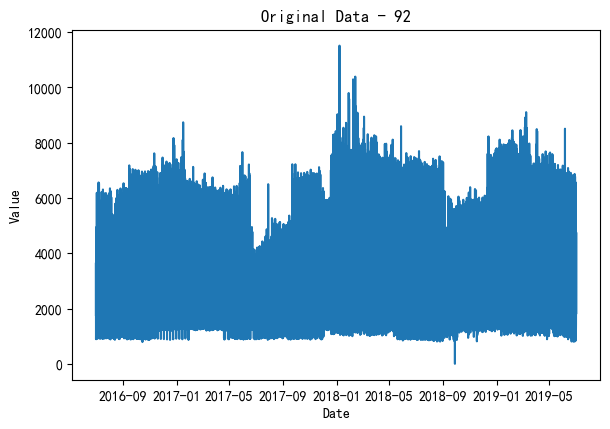

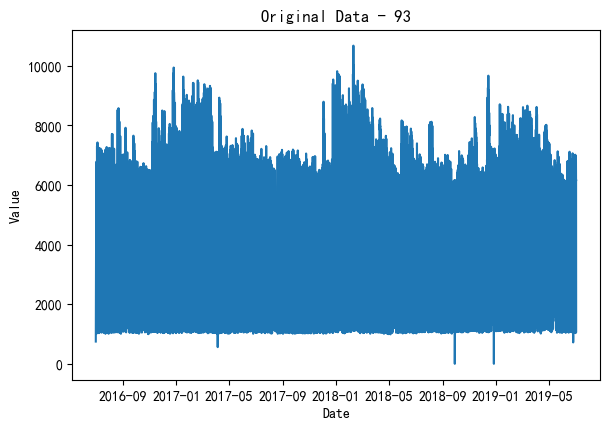

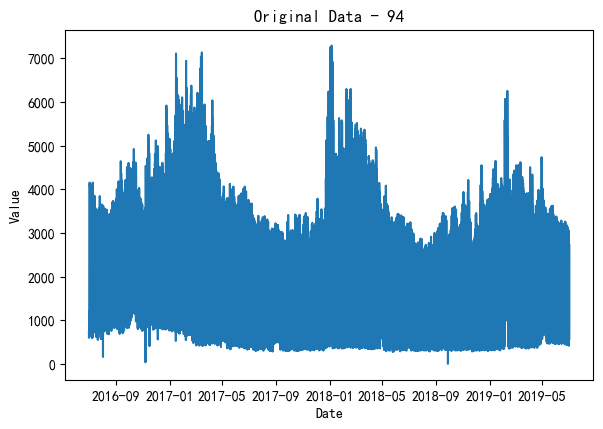

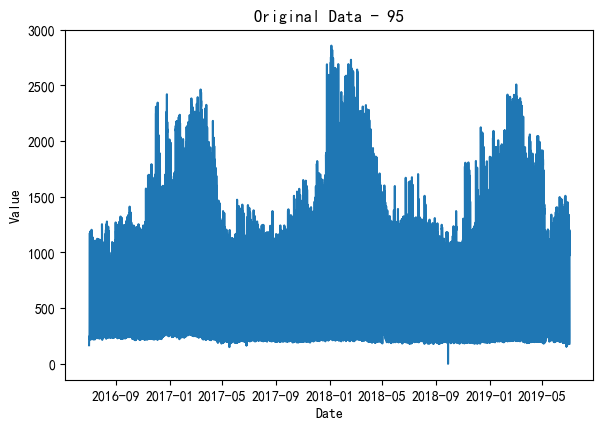

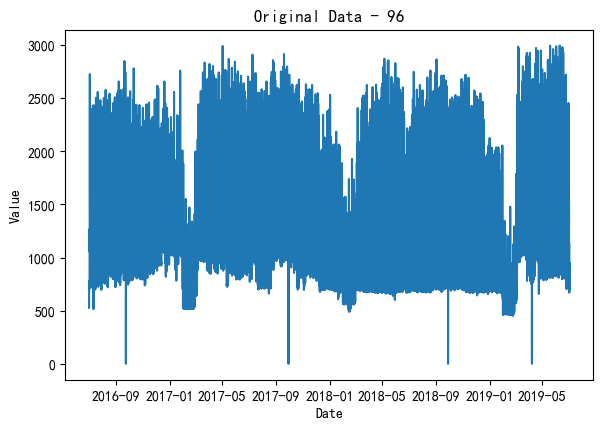

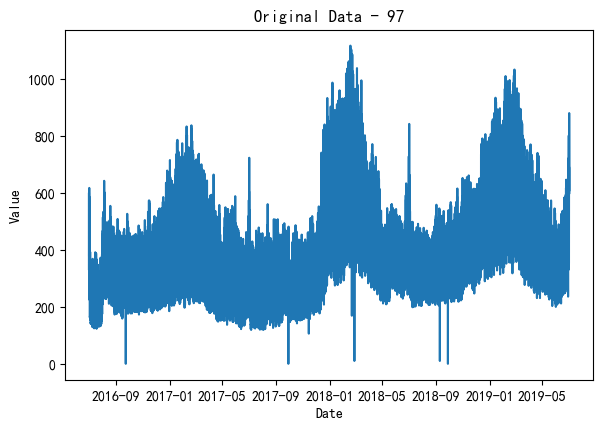

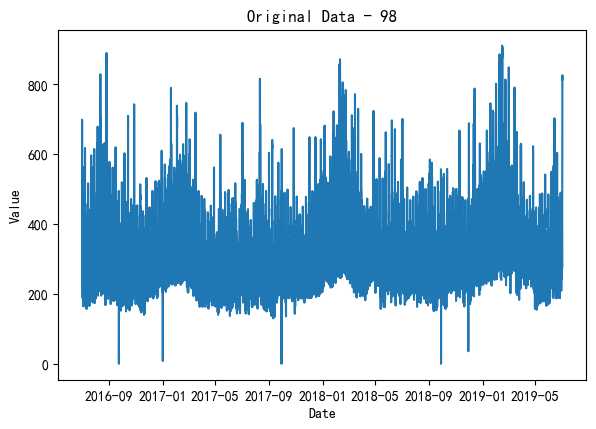

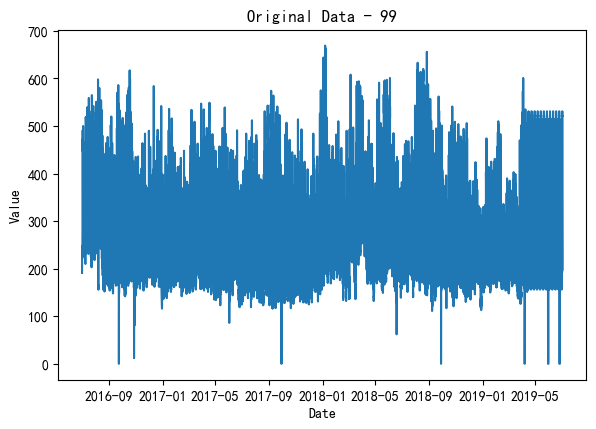

In [35]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import boxcox, yeojohnson
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = [u'simHei']
plt.rcParams['axes.unicode_minus'] = False

# 加载数据
data = pd.read_csv('./dataset/electricity/electricity.csv')

# 将日期转换为日期格式
data['date'] = pd.to_datetime(data['date'])
# 提取年、月、日和小时信息，并添加为新的列
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['hour'] = data['date'].dt.hour

# 将新添加的列移到数据框的前面
cols = ['year', 'month', 'day', 'hour'] + list(data.columns[:-4])
data = data[cols]
data=data.drop(columns=['date'])
# 选择一个或多个特征列进行可视化
features_to_visualize = [i for i in range(100)]  # 替换为你要可视化的列名

# 对数据进行不同的变换
for feature in features_to_visualize:
    feature=str(feature)
    original_data = data[feature]
    
    # # 对数变换
    # log_data = np.log1p(original_data)
    
    # # 平方根变换
    # sqrt_data = np.sqrt(original_data)
    
    # # Yeo-Johnson 变换
    # yj_data, _ = yeojohnson(original_data)
    
    # # Box-Cox 变换
    # if (original_data <= 0).any():
    #     original_data = original_data - original_data.min() + 1
    # bc_data, _ = boxcox(original_data)

    # 原始数据可视化
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(data['date'], original_data, label='Original Data')
    plt.title(f'Original Data - {feature}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    
    # # 对数变换可视化
    # plt.subplot(2, 2, 2)
    # plt.plot(data['date'], log_data, label='Log Transform', color='orange')
    # plt.title(f'Log Transform - {feature}')
    # plt.xlabel('Date')
    # plt.ylabel('Log(Value)')
    
    # # 平方根变换可视化
    # plt.subplot(2, 2, 3)
    # plt.plot(data['date'], sqrt_data, label='Square Root Transform', color='green')
    # plt.title(f'Square Root Transform - {feature}')
    # plt.xlabel('Date')
    # plt.ylabel('Sqrt(Value)')
    
    # # Yeo-Johnson 变换可视化
    # plt.subplot(2, 2, 4)
    # plt.plot(data['date'], yj_data, label='Yeo-Johnson Transform', color='purple')
    # plt.title(f'Yeo-Johnson Transform - {feature}')
    # plt.xlabel('Date')
    # plt.ylabel('Transformed Value')
    
    # plt.tight_layout()
    # plt.show()

    # # Box-Cox 变换可视化
    # plt.figure(figsize=(12, 6))
    # plt.plot(data['date'], bc_data, label='Box-Cox Transform', color='red')
    # plt.title(f'Box-Cox Transform - {feature}')
    # plt.xlabel('Date')
    # plt.ylabel('Transformed Value')
    # plt.legend()
    # plt.show()


In [9]:

# 特征和目标都设为最后321列
num_features = 324
features = data.columns[-324:]  # 最后321列作为特征
target = data.columns[-321:]  # 目标列和特征列一样

# 数据标准化
scaler_target = MinMaxScaler()
data[target] = scaler_target.fit_transform(data[target])

# 训练集和测试集划分
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)


In [13]:
def create_sequences(features, targets, seq_length):
    xs, ys = [], []
    for i in range(len(features) - seq_length):
        x = features[i:i + seq_length]
        y = targets[i + seq_length]  # 目标变量是多列
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_lengths = [96]  # 设定时间步长
for seq_length in seq_lengths:
    X_train, y_train = create_sequences(train_data[features].values, train_data[target].values, seq_length)
    X_test, y_test = create_sequences(test_data[features].values, test_data[target].values, seq_length)

    # 检查目标数据的维度
    print(f'y_train shape: {y_train.shape}')
    print(f'y_test shape: {y_test.shape}')

    # 检查是否有可用的GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # 构建LSTM模型
    class LSTMModel(nn.Module):
        def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
            super(LSTMModel, self).__init__()
            self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
            self.fc = nn.Linear(hidden_dim, hidden_dim)  # 线性化处理
            self.final_fc = nn.Linear(hidden_dim, output_dim)  # 最终输出层

        def forward(self, x):
            out, _ = self.lstm(x)
            out = self.fc(out[:, -1, :])  # LSTM 最后一个时间步的输出
            out = self.final_fc(out)  # 最终输出层
            return out


    input_dim = num_features
    hidden_dim = 64
    num_layers = 2
    output_dim = 321  # 输出维度与目标数据列数一致

    model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # 将数据加载到GPU
    train_loader = DataLoader(
        TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)),
        batch_size=64, shuffle=True)
    test_loader = DataLoader(
        TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)),
        batch_size=64, shuffle=False)

    # 记录每个 epoch 的损失值
    losses = []

    # 训练模型
    for epoch in range(20):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * X_batch.size(0)  # 累加每个 batch 的损失

        epoch_loss /= len(train_loader.dataset)  # 计算平均损失
        losses.append(epoch_loss)
        print(f'Epoch {epoch + 1}: Train loss = {epoch_loss}')

    # 测试模型并计算MSE和MAE
    model.eval()
    y_true, y_pred_list = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            y_pred_list.append(y_pred.cpu().numpy())
            y_true.append(y_batch.cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred_list = np.concatenate(y_pred_list)

    # # 检查预测数据和实际数据的形状
    # print(f'y_true shape: {y_true.shape}')
    # print(f'y_pred_list shape: {y_pred_list.shape}')

    # # # 反向归一化
    # y_true = scaler_target.inverse_transform(y_true)
    # y_pred_list = scaler_target.inverse_transform(y_pred_list)

    # 计算MSE和MAE
    mse = mean_squared_error(y_true, y_pred_list)
    mae = mean_absolute_error(y_true, y_pred_list)

    print(f'Test MSE = {mse}')
    print(f'Test MAE = {mae}')

# 绘制预测结果
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_true)), y_true[:, -1], label='实际值')  # 仅绘制第一列数据
plt.plot(np.arange(len(y_pred_list)), y_pred_list[:, -1], label='预测值')  # 仅绘制第一列数据
plt.legend()
plt.show()

# 绘制训练损失折线图
plt.figure(figsize=(12, 6))
plt.plot(range(1, 21), losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

y_train shape: (20947, 321)
y_test shape: (5165, 321)



KeyboardInterrupt



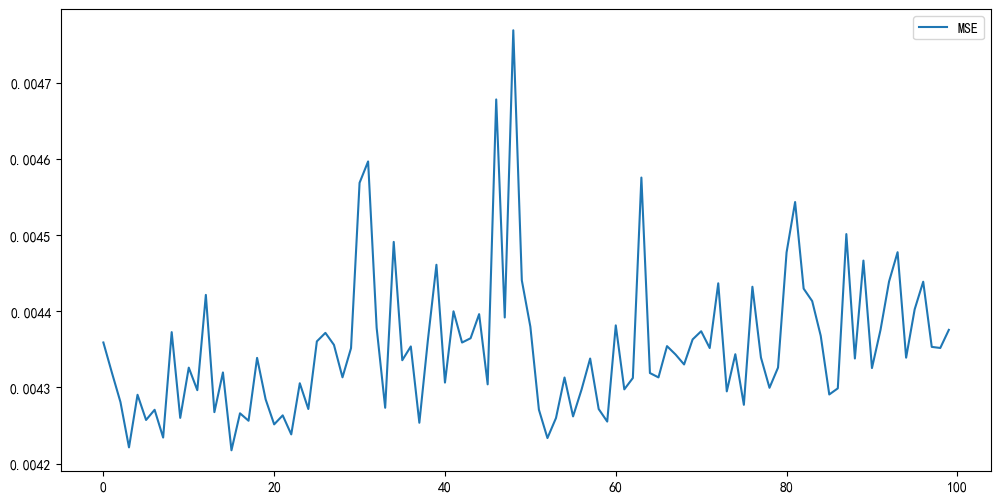

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(tol_mse)), tol_mse, label='MSE')
plt.legend()
plt.show()

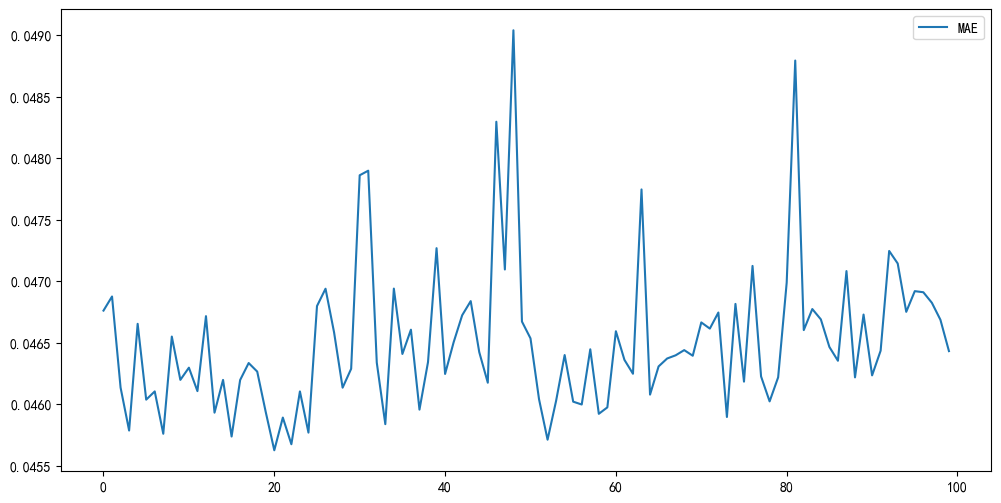

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(tol_mae)), tol_mae, label='MAE')
plt.legend()
plt.show()

In [72]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# 加载数据
data = pd.read_csv('./dataset/electricity/electricity.csv')

# 将日期转换为日期格式
data['date'] = pd.to_datetime(data['date'])
# 提取年、月、日和小时信息，并添加为新的列
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['hour'] = data['date'].dt.hour

# 将新添加的列移到数据框的前面
cols = ['year', 'month', 'day', 'hour'] + list(data.columns[:-4])
data = data[cols]
data = data.drop(columns=['date'])

# 提取特征列，假设它们从第5列开始
features = data.iloc[:, 4:].values

# 对每一列特征进行FFT
fft_features = np.fft.fft(features, axis=0)

# 获取频率域的幅度谱
magnitude = np.abs(fft_features)

# 设定输入序列长度和预测长度
seq_len = 96
pred_len = 96

# 准备LSTM输入输出对
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len, pred_len):
        self.data = data
        self.seq_len = seq_len
        self.pred_len = pred_len
    
    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len
    
    def __getitem__(self, idx):
        X = self.data[idx:idx+self.seq_len]
        y = self.data[idx+self.seq_len:idx+self.seq_len+self.pred_len]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

dataset = TimeSeriesDataset(magnitude, seq_len, pred_len)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 构建LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

input_size = magnitude.shape[1]  # 特征数量
hidden_size = 64
output_size = magnitude.shape[1]  # 与预测目标的特征数量匹配

model = LSTMModel(input_size, hidden_size, output_size)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 20

for epoch in range(num_epochs):
    for batch_x, batch_y in dataloader:
        # 前向传播
        outputs = model(batch_x)
        #print(outputs.shape,batch_y.shape)
        loss = criterion(outputs, batch_y)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 评估模型
with torch.no_grad():
    total_loss = 0
    for batch_x, batch_y in dataloader:
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        total_loss += loss.item() * batch_x.size(0)
    
    avg_loss = total_loss / len(dataset)
print(f"Test Loss: {avg_loss:.4f}")


Epoch [1/20], Loss: 5250944598016.0000
Epoch [2/20], Loss: 70823845888.0000
Epoch [3/20], Loss: 46171992064.0000
Epoch [4/20], Loss: 99495632896.0000
Epoch [5/20], Loss: 239093399552.0000
Epoch [6/20], Loss: 248100864000.0000
Epoch [7/20], Loss: 5275671592960.0000
Epoch [8/20], Loss: 54980833280.0000
Epoch [9/20], Loss: 439805837312.0000
Epoch [10/20], Loss: 804534419456.0000
Epoch [11/20], Loss: 181859745792.0000
Epoch [12/20], Loss: 35845357568.0000
Epoch [13/20], Loss: 47742091264.0000
Epoch [14/20], Loss: 189783670784.0000
Epoch [15/20], Loss: 4870287392768.0000
Epoch [16/20], Loss: 60701220864.0000
Epoch [17/20], Loss: 5619734544384.0000
Epoch [18/20], Loss: 5274992115712.0000
Epoch [19/20], Loss: 5430757556224.0000
Epoch [20/20], Loss: 46513233920.0000
Test Loss: 1399456173796.3921
